In [1]:
##### CS480 Project #####
# Harmony generator 
# Lang Su
# 20630791
# l26su@edu.uwaterloo.ca

In [2]:
# load dataset
import numpy as np
import pandas as pd
import os
from music21 import *
import matplotlib.pyplot as plt

In [3]:
# convert a two track midi file to Music21 note/chord 
# returns track list: right hand (melody) and left hand (harmony)

# given a chord object, return a string

def get_first_note_from_chord(chord):
    note_lst = [str(n) for n in chord.pitches]
    return note_lst[0]


def midi_to_note(path):
    piece = converter.parse(path)
    
    if len(piece.parts) != 2:
        print(path)
        return None
    #print(piece.parts[0].__dict__)

    track_list = []
    
    # for each track in the midi file
    for part in piece.parts:
        
        note_to_parse = part.recurse() 

        track = []

        for element in note_to_parse:
            # For note: We use pitch's string expression
            if isinstance(element, note.Note):
                track.append(str(element.pitch))

            # For chord: We take the first note in the chord 
            elif isinstance(element, chord.Chord):
                track.append(get_first_note_from_chord(element))
                
            # For Rest: A rest is a note with no pitch of time length 1.0
            # We express it using a *
            elif isinstance(element, note.Rest):
                track.append("*")
            
        track_list.append(track)

    return track_list


    
        
#sample_midi = "../dataset_midi/midi_songs/balamb.mid"

#note_string = midi_to_note(sample_midi)
#print(note_string[0])
#mf = midi.translate.streamToMidiFile(no_chord)
#no_chord[0].show('midi')
#no_chord[1].show('midi')

In [4]:
from sklearn.model_selection import train_test_split
def get_input(path_to_dir):
    input_streams = [] # right hand
    output_streams = [] # left hand
    max_input_seq_num = 0
    max_output_seq_num = 0
    counter = 0
    for file in os.listdir(path_to_dir):
        if file.endswith(".mid"):
            full_path = os.path.join(path_to_dir, file)
            result = midi_to_note(full_path)
            if result!=None: # if qualified 2 track midi
                input_streams.append(result[0])
                output_streams.append(result[1])
                counter += 1 

    # decide which stream has the longest length
    max_input_seq_num = max(len(input_stream) for input_stream in input_streams)
    max_output_seq_num = max(len(output_stream) for output_stream in output_streams)
    
    print("Finished {} of midi files. Max input stream length {}, max output stream length {}"\
          .format(str(counter), str(max_input_seq_num), str(max_output_seq_num)))
    
    return input_streams, output_streams, max_input_seq_num, max_output_seq_num

total_input_streams, total_output_streams, max_input_seq_num, max_output_seq_num \
= get_input("../dataset_midi/train/")
train_input_streams, test_input_streams, train_output_streams, test_output_streams \
= train_test_split(total_input_streams, total_output_streams, test_size=0.1, random_state=42)
print(len(train_input_streams))
print(len(train_output_streams))
print(len(test_input_streams))
print(len(test_output_streams))

../dataset_midi/train/6c29793a140a811d0c45ce03c1c93a28.mid
../dataset_midi/train/07c5807d0d927dcd0980f86024e5208b.mid
../dataset_midi/train/92bbd31f8e0e43a7da8a6295b251725f.mid
../dataset_midi/train/5b69b9cb83065d403869739ae7f0995e.mid
../dataset_midi/train/d3a7f48c12e697d50c8a7ae7684644ef.mid
../dataset_midi/train/298f587406c914fad5373bb689300433.mid
Finished 114 of midi files. Max input stream length 368, max output stream length 343
102
102
12
12


Found 79 keys used in all midi files


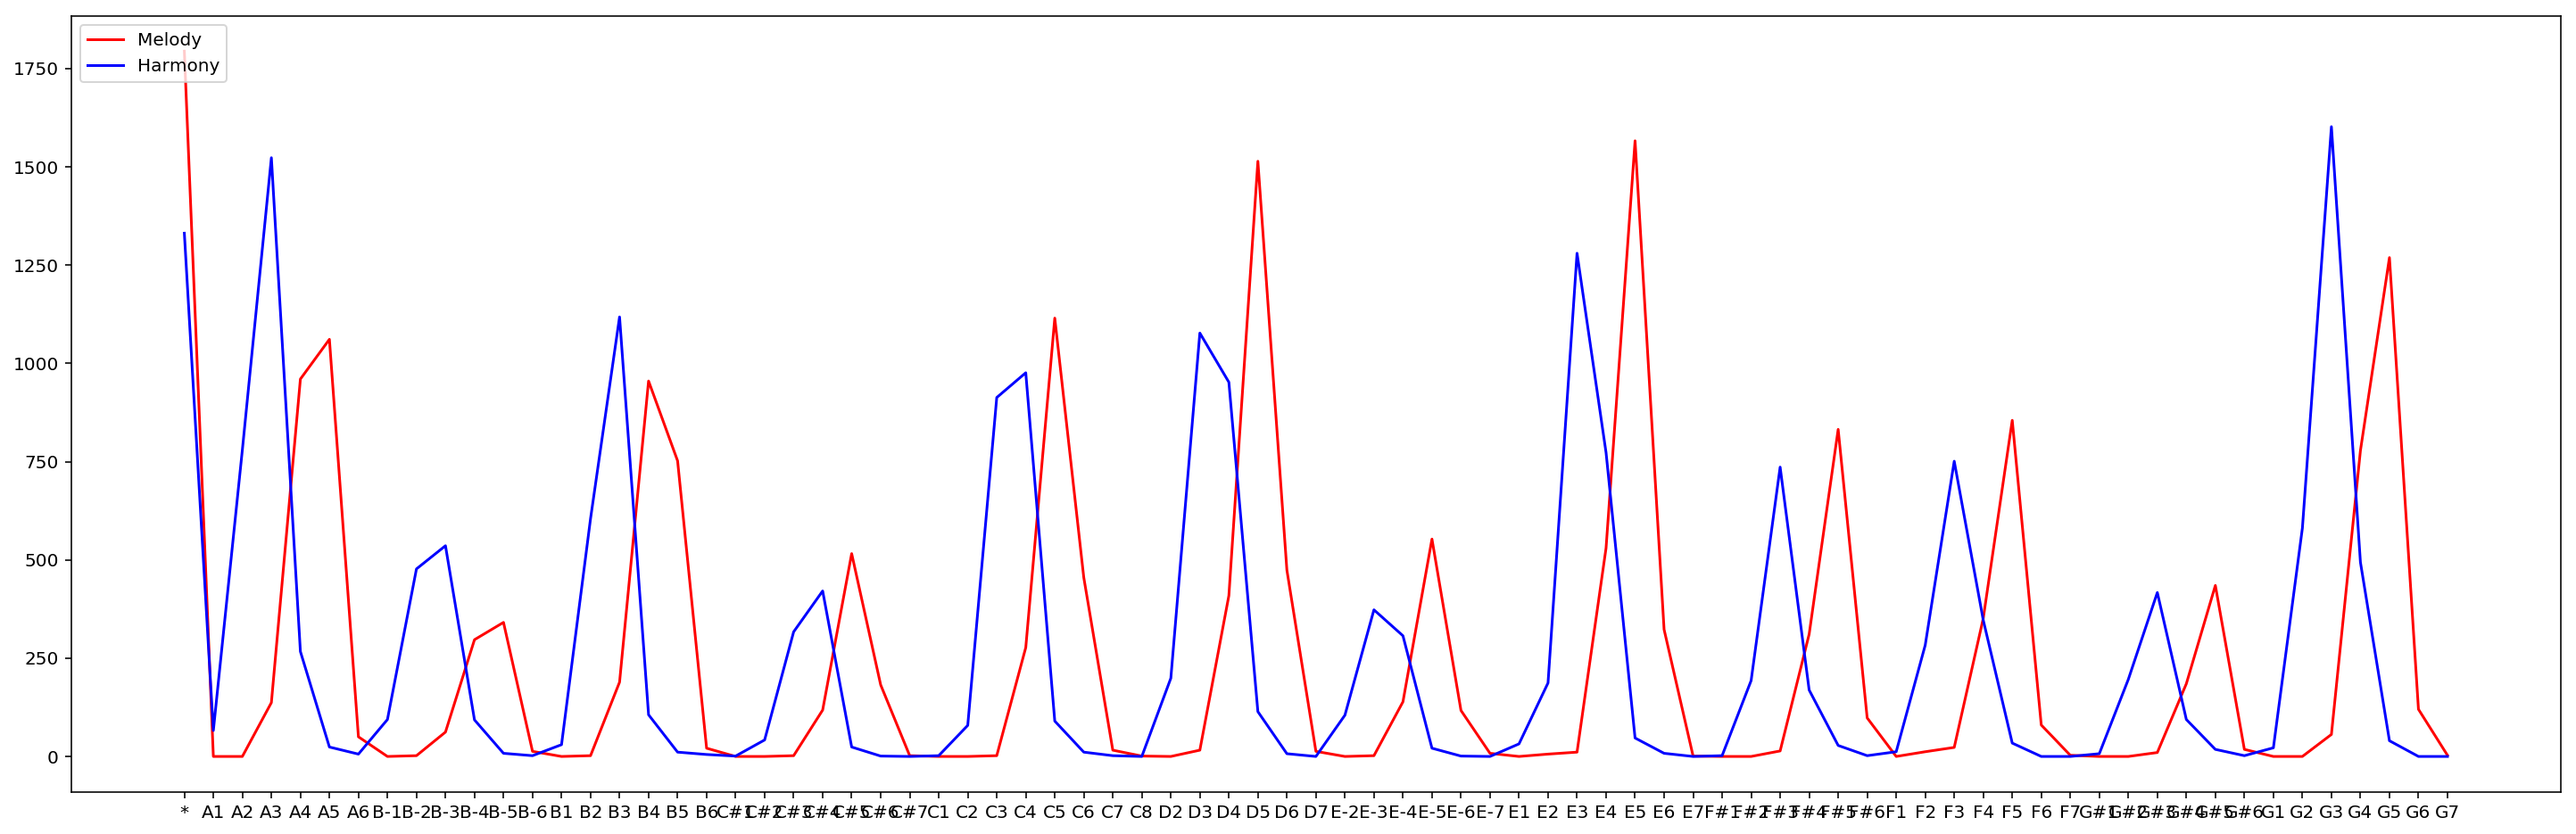

In [5]:
#print(input_stream[0])
# get key set in the input stream. 
# Like get all characters set from an article (maybe z is not seen anywhere)
import copy
import matplotlib.pyplot as plt

def get_all_keys(input_streams, output_streams):
    all_keys = [] # dot is also consider a "character" that shape our chord string
    input_all_freq = []
    output_all_freq = []
    for song in input_streams:
        for s in song:
            if s not in all_keys:
                all_keys.append(s)
                input_all_freq.append(1)
            else:
                idx = all_keys.index(s)
                input_all_freq[idx] += 1

    output_all_freq = [0] * len(input_all_freq)
    
    for song in output_streams:
        for s in song:
            if s not in all_keys:
                all_keys.append(s)
                output_all_freq.append(1)
            else:
                idx = all_keys.index(s)
                output_all_freq[idx] += 1

    input_all_freq = input_all_freq + [0] * (len(output_all_freq)-len(input_all_freq))
                
    return all_keys, input_all_freq, output_all_freq

            
all_keys, in_freq, out_freq = get_all_keys(train_input_streams, train_output_streams)
in_freq = [x for _,x in sorted(zip(copy.deepcopy(all_keys),copy.deepcopy(in_freq)))]
out_freq = [x for _,x in sorted(zip(copy.deepcopy(all_keys),copy.deepcopy(out_freq)))]
all_keys = sorted(all_keys)

key_idx_pair = dict([(char, i) for i, char in enumerate(all_keys)])

plt.figure(figsize=(25,8))
plt.plot(all_keys, in_freq, 'r', label="Melody")
plt.plot(all_keys, out_freq, 'b', label="Harmony")
plt.legend(loc='upper left')

print("Found {} keys used in all midi files".format(str(len(all_keys))))

In [6]:
def onehot_encode(input_streams, output_streams, max_input_seq_num, max_output_seq_num, all_keys):
    encoder_input_data = np.zeros(
        (len(input_streams), max_input_seq_num, len(all_keys)))
    decoder_input_data = np.zeros(
        (len(output_streams), max_output_seq_num, len(all_keys)))
    decoder_target_data = np.zeros(
        (len(output_streams), max_output_seq_num, len(all_keys)))

    print(encoder_input_data.shape)
    print(decoder_input_data.shape)

    for i, (input_stream, output_stream) in enumerate(zip(input_streams, output_streams)):
        for t, char in enumerate(input_stream):
            encoder_input_data[i, t, key_idx_pair.get(char)] = 1.
        for t, char in enumerate(output_stream):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, key_idx_pair.get(char)] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, key_idx_pair.get(char)] = 1.
    return encoder_input_data, decoder_input_data, decoder_target_data

train_encoder_input_data, train_decoder_input_data, train_decoder_target_data \
= onehot_encode(train_input_streams, train_output_streams, max_input_seq_num, max_output_seq_num, all_keys)

test_encoder_input_data, test_decoder_input_data, test_decoder_target_data \
= onehot_encode(test_input_streams, test_output_streams, max_input_seq_num, max_output_seq_num, all_keys)


(102, 368, 79)
(102, 343, 79)
(12, 368, 79)
(12, 343, 79)


In [24]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint

def compile_and_train(batch_size, epochs, latent_dim, num_samples, output_file_name, cont=False):
    # encoder model
    # input
    encoder_inputs = Input(shape=(None, len(all_keys)))
    encoder = LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # Encoder States
    encoder_states = [state_h, state_c]

    # decoder model
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    # input
    decoder_inputs = Input(shape=(None, len(all_keys)))
    decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
    # Activation Layer
    decoder_dense = Dense(len(all_keys), activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Run training
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    if cont:# continue training
        model.load_weights(output_file_name)

    filepath = output_file_name    
    checkpoint = ModelCheckpoint(
        filepath, monitor='loss', 
        verbose=1,        
        save_best_only=True,        
        mode='min'
    )    
    callbacks_list = [checkpoint]     

    model.fit([train_encoder_input_data, train_decoder_input_data], train_decoder_target_data,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_split=0.1,
              callbacks=callbacks_list)
    # Save model
    model.save(output_file_name)

    train_loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    tot_epoch = model.history.epoch
    config_detail = [batch_size, epochs, latent_dim, num_samples]
    
    total_history.append([config_detail, train_loss, val_loss, tot_epoch])
    #plt.plot(tot_epoch, train_loss, label="Train Loss")
    #plt.plot(tot_epoch, val_loss, label="Validation Loss")
    #plt.legend(loc='upper_left')
    
    
    
total_history = []

num_samples = len(train_input_streams)  # Number of samples to train on.
epochs = 50  # Number of epochs to train for.
batch_sizes = [16]
latent_dims = [256]  # Latent dimensionality of the encoding space.

for batch_size in batch_sizes:
    for latent_dim in latent_dims:
        output_file_name = "./weights_epoch_60/batch_{}_latent_{}_.h5".format(str(batch_size), str(latent_dim))
        compile_and_train(batch_size, epochs, latent_dim, num_samples, output_file_name, True)

Train on 91 samples, validate on 11 samples
Epoch 1/50
91/91 [==============================] - 7s 77ms/step - loss: 1.1570 - val_loss: 1.6691

Epoch 00001: loss improved from inf to 1.15703, saving model to ./weights_epoch_60/batch_16_latent_256_.h5


/Users/kevinsu/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_18 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_17/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_17/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
91/91 [==============================] - 5s 54ms/step - loss: 1.1196 - val_loss: 1.5750

Epoch 00002: loss improved from 1.15703 to 1.11962, saving model to ./weights_epoch_60/batch_16_latent_256_.h5
Epoch 3/50
91/91 [==============================] - 5s 56ms/step - loss: 1.0178 - val_loss: 1.6279

Epoch 00003: loss improved from 1.11962 to 1.01784, saving model to ./weights_epoch_60/batch_16_latent_256_.h5
Epoch 4/50
91/91 [==============================] - 5s 53ms/step - loss: 0.9867 - val_loss: 1.5939

Epoch 00004: loss improved from 1.01784 to 0.98666, saving model to ./weights_epoch_60/batch_16_latent_256_.h5
Epoch 5/50
91/91 [==============================] - 5s 56ms/step - loss: 0.9784 - val_loss: 1.6206

Epoch 00005: loss improved from 0.98666 to 0.97840, saving model to ./weights_epoch_60/batch_16_latent_256_.h5
Epoch 6/50
91/91 [==============================] - 5s 52ms/step - loss: 0.9953 - val_loss: 1.6019

Epoch 00006: loss did not improve from 0.97840
Epoch 7/5

91/91 [==============================] - 5s 53ms/step - loss: 0.7511 - val_loss: 1.8158

Epoch 00048: loss did not improve from 0.74214
Epoch 49/50
91/91 [==============================] - 5s 52ms/step - loss: 0.7231 - val_loss: 1.8380

Epoch 00049: loss improved from 0.74214 to 0.72311, saving model to ./weights_epoch_60/batch_16_latent_256_.h5
Epoch 50/50
91/91 [==============================] - 5s 54ms/step - loss: 0.7092 - val_loss: 1.8908

Epoch 00050: loss improved from 0.72311 to 0.70916, saving model to ./weights_epoch_60/batch_16_latent_256_.h5


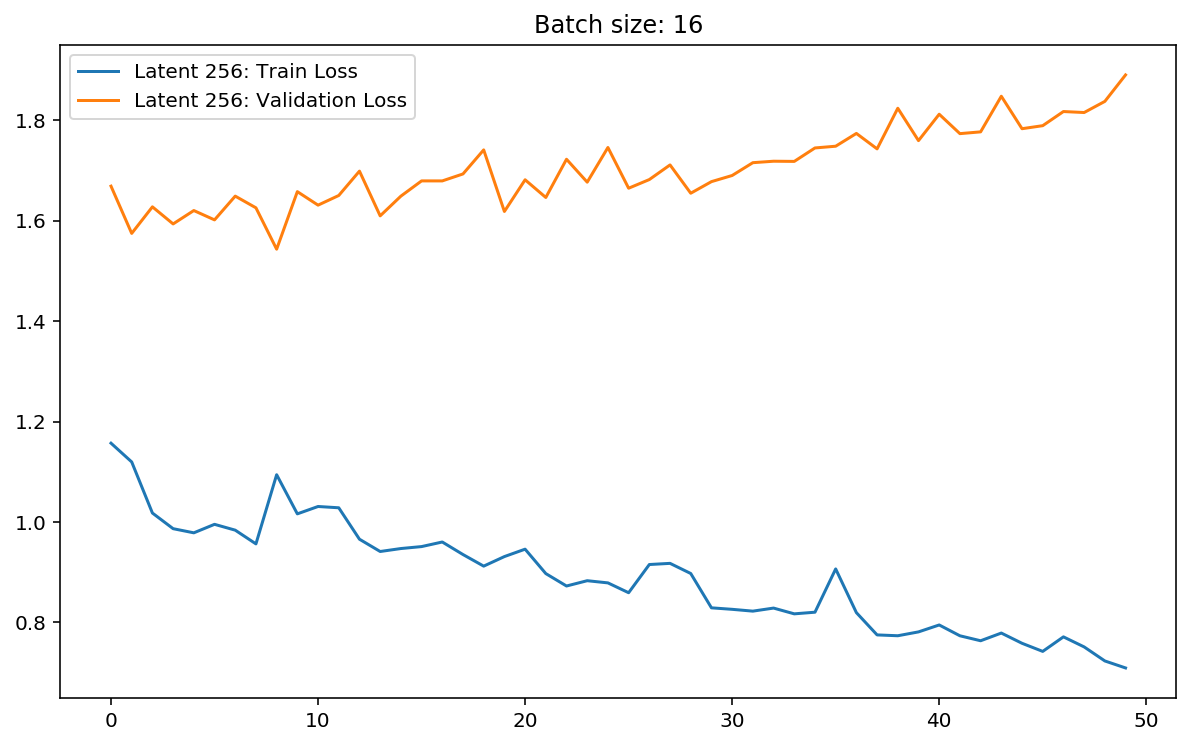

Batch Size: 16 Latent_dim: 256


In [25]:
def plot_performance(total_history):
    counter = 0
    plt.rcParams["figure.figsize"] = [10,6]
    for each_config in total_history:
        config = each_config[0]
        train_loss = each_config[1]
        val_loss = each_config[2]
        tot_epoch = each_config[3]
        plt.plot(tot_epoch, train_loss, label="Latent {}: Train Loss".format(str(config[2])))
        plt.plot(tot_epoch, val_loss, label="Latent {}: Validation Loss".format(str(config[2])))
        plt.legend(loc='best')
        #if counter >= 2:
        #    counter = 0
        plt.title("Batch size: {}".format(str(config[0])))
        plt.show()
        #else:
        #    counter += 1
        print("Batch Size: {} Latent_dim: {}".format(str(config[0]), str(config[2])))
plot_performance(total_history)


In [41]:

latent_dim = 256
# encoder model
# input
encoder_inputs = Input(shape=(None, len(all_keys)))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Encoder States
encoder_states = [state_h, state_c]

# decoder model
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
# input
decoder_inputs = Input(shape=(None, len(all_keys)))
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs, initial_state=encoder_states)
# Activation Layer
decoder_dense = Dense(len(all_keys), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights("./weights/batch_1_latent_256_.h5")

#########################################################

# encoder model
# used when making a prediction for a new source sequence.
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model 
# use when making a prediction for a new source sequence.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# define model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in key_idx_pair.items())
reverse_target_char_index = dict(
    (i, char) for char, i in key_idx_pair.items())


In [27]:
def decode_stream(input_stream, first_token):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_stream)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(all_keys)))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, key_idx_pair[first_token]] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        
        #print(output_tokens)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (len(decoded_sentence) > max_output_seq_num):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(all_keys)))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]
    

    return decoded_sentence

In [40]:
# convert a list of note string to a list of note object
def note_to_midi(seq):
    offset = 0
    output_notes = []

    for i in range(len(seq)):
        pattern = seq[i]
        new_note = None
        # if it's a rest
        if pattern == '*':
            new_note = note.Rest()
            new_note.offset = offset
        # if it's a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
        
        output_notes.append(new_note)
        offset += 0.5

    return output_notes

# The function takes an encoded melody matrix and the original melody note list
# make a left-hand piano stream and gives the option of playing both melody, harmony 
# and the combined part
def generate_music(input_data_matrix, input_data_seq, output_data_seq, idx):
    input_mat = input_data_matrix[idx:idx+1]
    input_seq = input_data_seq[idx]
    output_seq = output_data_seq[idx] # used for retrive the first token for enlightment
    # main melody 
    melody = note_to_midi(input_seq)
    melody = stream.Part(melody)
    # left hand generated by model
    harmony_seq = decode_stream(input_mat, output_seq[0])
    
    all_keys = [] 
    all_freq = []
    for key in harmony_seq:
        if key not in all_keys:
            all_keys.append(key)
            all_freq.append(1)
        else:
            idx = all_keys.index(key)
            all_freq[idx] += 1
    print(all_freq)

    harmony = note_to_midi(harmony_seq)
    harmony = stream.Part(harmony)
    
    final_score = stream.Score()
    final_score.insert(0, melody)
    final_score.insert(0, harmony)
    
    melody.show('midi')
    #melody.show('text')
    harmony.show('midi')
    #harmony.show("text")
    final_score.show('midi')
    #final_score.show()
    
generate_music(test_encoder_input_data, test_input_streams, test_output_streams, 5)

[42, 39, 19, 45, 24, 24, 46, 24, 46, 21, 1, 13]


In [44]:
generate_music(test_encoder_input_data, test_input_streams, test_output_streams, 4)

[13, 53, 33, 6, 6, 21, 27, 4, 11, 3, 8, 18, 2, 12, 23, 19, 2, 17, 26, 7, 3, 19, 6, 2, 2, 1]


In [267]:
path = "../maestro-v1.0.0/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.midi"
piece = converter.parse(path)
note_to_parse = piece.parts[0].recurse() 
for note in note_to_parse:
    print(note)
    print(note.duration)

Piano
<music21.duration.Duration 0.0>
<music21.tempo.MetronomeMark animato Quarter=120.0>
<music21.duration.Duration 0.0>
<music21.meter.TimeSignature 4/4>
<music21.duration.Duration 0.0>
<music21.stream.Voice 0xd6cca07f0>
<music21.duration.Duration 302.0>
<music21.note.Rest rest>
<music21.duration.Duration 2.0>
<music21.note.Note E>
<music21.duration.Duration 11.0>
<music21.note.Rest rest>
<music21.duration.Duration 7/3>
<music21.note.Note E->
<music21.duration.Duration 1.0>
<music21.note.Rest rest>
<music21.duration.Duration 3463/12>
<music21.note.Note A>
<music21.duration.Duration 0.5>
<music21.note.Note G#>
<music21.duration.Duration 0.5>
<music21.chord.Chord B4 G#3>
<music21.duration.Duration 0.5>
<music21.note.Note E>
<music21.duration.Duration 2/3>
<music21.note.Note E->
<music21.duration.Duration 0.5>
<music21.note.Note E>
<music21.duration.Duration 0.75>
<music21.note.Note F#>
<music21.duration.Duration 0.5>
<music21.note.Note C#>
<music21.duration.Duration 1/3>
<music21.note.

<music21.duration.Duration 0.25>
<music21.note.Note F#>
<music21.duration.Duration 5/3>
<music21.chord.Chord C4 E-5>
<music21.duration.Duration 0.25>
<music21.note.Note F#>
<music21.duration.Duration 8/3>
<music21.note.Note G#>
<music21.duration.Duration 0.25>
<music21.note.Note E->
<music21.duration.Duration 0.25>
<music21.note.Note E->
<music21.duration.Duration 0.25>
<music21.note.Note C#>
<music21.duration.Duration 0.0>
<music21.note.Note E->
<music21.duration.Duration 0.25>
<music21.note.Note F#>
<music21.duration.Duration 5/3>
<music21.chord.Chord A2 E3>
<music21.duration.Duration 0.0>
<music21.note.Note E->
<music21.duration.Duration 1/3>
<music21.note.Note A>
<music21.duration.Duration 0.25>
<music21.note.Note B>
<music21.duration.Duration 1.0>
<music21.note.Note E>
<music21.duration.Duration 0.25>
<music21.note.Note C#>
<music21.duration.Duration 1/3>
<music21.chord.Chord E4 G#3>
<music21.duration.Duration 0.25>
<music21.note.Note E>
<music21.duration.Duration 0.25>
<music21.n

In [271]:
import pretty_midi
midi_sample = pretty_midi.PrettyMIDI(path)
for instrument in midi_sample.instruments:
    for i,note in enumerate(instrument.notes):
        print(note)

Note(start=0.982292, end=1.294792, pitch=64, velocity=52)
Note(start=1.282292, end=1.586458, pitch=68, velocity=71)
Note(start=1.538542, end=1.791667, pitch=71, velocity=78)
Note(start=1.784375, end=2.038542, pitch=76, velocity=76)
Note(start=2.036458, end=2.279167, pitch=75, velocity=77)
Note(start=1.782292, end=2.405208, pitch=56, velocity=50)
Note(start=2.282292, end=2.527083, pitch=76, velocity=71)
Note(start=2.529167, end=2.593750, pitch=75, velocity=70)
Note(start=2.597917, end=2.658333, pitch=73, velocity=69)
Note(start=2.671875, end=2.745833, pitch=75, velocity=70)
Note(start=2.747917, end=2.814583, pitch=73, velocity=81)
Note(start=2.825000, end=3.069792, pitch=71, velocity=77)
Note(start=3.054167, end=3.398958, pitch=73, velocity=82)
Note(start=2.418750, end=3.650000, pitch=57, velocity=52)
Note(start=3.592708, end=3.879167, pitch=56, velocity=45)
Note(start=3.344792, end=4.096875, pitch=76, velocity=72)
Note(start=3.857292, end=4.151042, pitch=54, velocity=41)
Note(start=4.1

In [144]:
input_streams, output_streams, max_input_seq_num, max_output_seq_num \
= get_input("../dataset_midi/test/")

encoder_input_data = np.zeros(
    (len(input_streams), max_input_seq_num, len(all_keys)))
decoder_input_data = np.zeros(
    (len(output_streams), max_output_seq_num, len(all_keys)))
decoder_target_data = np.zeros(
    (len(output_streams), max_output_seq_num, len(all_keys)))

print(encoder_input_data.shape)
print(decoder_input_data.shape)

for i, (input_stream, output_stream) in enumerate(zip(input_streams, output_streams)):
    for t, char in enumerate(input_stream):
        encoder_input_data[i, t, key_idx_pair.get(char)] = 1.
    for t, char in enumerate(output_stream):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, key_idx_pair.get(char)] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, key_idx_pair.get(char)] = 1.

print(input_streams[0])

Finished 8 of midi files. Max input stream length 211, max output stream length 288
(8, 211, 77)
(8, 288, 77)
['G#6', 'E6', 'C#6', 'G#5', 'B5', 'F#5', 'G#5', 'E5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'E5', 'C#5', 'E5', 'F#5', 'G#5', 'E5', 'E-5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'C#5', 'B4', 'C#5', 'E5', 'C#5', 'B4', 'G#4', 'G#5', 'B5', 'C#5', 'G#5', 'E5', 'F#5', 'E5', 'F#5', 'G#5', 'E6', 'C#6', 'G#5', 'B5', 'G#5', 'B5', 'C#6', 'E6', 'C#6', 'F#4', 'C#5', 'E4', 'F#4', 'E4', 'B3', 'E4', 'C#4', 'G#4', 'F#4', 'B4', 'C#5', 'G#5', 'E5', 'F#5', 'G#5', 'B5', 'C#6', 'G#6', 'F#6', 'C#6', 'B4', 'B5', 'C#6', 'E6', 'C#6', 'G#6', 'F#6', 'B6', 'G#6', 'C#6', 'E6', 'F#6', 'C#5', 'E5', 'G#5', 'F#6', 'B6', 'G#6', 'C#6', 'G#5', 'F#5', 'G#5', 'B5', 'E5', 'E-5', 'F#4', '*', 'B4', '*', 'C#5', 'B

In [149]:
generate_music(encoder_input_data, input_streams, 1)

In [71]:
s = stream.Stream()
n = note.Note('B-4', type='half')
m = note.Note('E-5', type='half')
u = note.Note('B-4', type='half')
o = note.Note('E-5', type='half')
s.append(n)
s.append(m)
s.append(u)
s.append(o)
s.show('midi')